In [1]:
import gc
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

gc.collect()

0

In [3]:
# pri_df1을 gvkey별, datadate별로 정렬하고 adj_closed에 pct_change 적용
def calculate_pct_change_by_gvkey(df):
    """
    gvkey별로 그룹화하여 datadate로 정렬한 후 adj_closed에 pct_change 적용
    """
    # gvkey별, datadate별로 정렬
    df_sorted = df.sort_values(['PERMNO', 'date']).copy()

    # gvkey별로 그룹화하여 pct_change 계산
    df_sorted['adj_closed_pct_change'] = df_sorted.groupby(
        'PERMNO')['adj_closed'].pct_change()

    return df_sorted


def calculate_cap_rank(df):
    """
    각 datadate마다 시가총액(cap) 상위 120개 종목 선택
    """
    # datadate별 정렬 (내림차순으로 시총이 큰 순서)
    df_sorted = df.sort_values(['date', 'CAP'], ascending=[True, False]).copy()

    # datadate별 cap 기준으로 rank (1이 가장 큰 시총)
    df_sorted['RANK'] = df_sorted.groupby(
        'date')['CAP'].rank(ascending=False, method='first')

    # 상위 120개만 반환
    return df_sorted[df_sorted['RANK'] <= 120]


In [4]:
df_ = pd.read_parquet('data/daily_price.parquet', columns=['date']).reset_index()

os.makedirs('data/daily_cap', exist_ok=True)

date_lst =np.sort(np.unique(df_['date']))

In [5]:
for date in tqdm(date_lst):
    date_str = str(date)
    df = pd.read_parquet('data/daily_price.parquet', filters=[('date', '==', date_str), ('SHROUT', '>', 0)]).reset_index().dropna()

    df['date'] = pd.to_datetime(df['date'])
    df['adj_closed'] = df['PRC'] / df['CFACPR']
    df['adj_closed'] = df['adj_closed'].replace([np.inf, -np.inf], 0)
    df['CAP'] = df['PRC']*df['SHROUT']
    df = df[['date', 'PERMNO', 'TICKER', 'COMNAM', 'adj_closed', 'VOL', 'CAP']]
    df_1 = calculate_cap_rank(df)
    
    df_1.to_parquet(f'data/daily_cap/{date}.parquet')
    del df, df_1
    gc.collect()
    

  0%|          | 0/3784 [00:00<?, ?it/s]

100%|██████████| 3784/3784 [44:42<00:00,  1.41it/s] 


In [6]:
df_1 = pd.DataFrame()
for date in tqdm(date_lst):
    date_str = str(date)
    df = pd.read_parquet(f'data/daily_cap/{date}.parquet')
    df_1 = pd.concat([df_1, df], axis=0)

100%|██████████| 3784/3784 [00:38<00:00, 97.99it/s] 


In [ ]:
df_2 = calculate_pct_change_by_gvkey(df_1)

rank_df = df_2.pivot_table(
    index='date',
    columns='PERMNO',
    values='RANK'
).loc['2010-05-02':'2025-07-31', :]

returns_df = df_2.pivot_table(
    index='date',
    columns='PERMNO',
    values='adj_closed_pct_change'
).loc['2010-05-02':'2025-07-31', :]

cap_df = df_2.pivot_table(
    index='date',
    columns='PERMNO',
    values='CAP'
).loc['2010-05-02':'2025-07-31', :]

rank_df.index = pd.to_datetime(rank_df.index)
returns_df.index = pd.to_datetime(returns_df.index)
cap_df.index = pd.to_datetime(cap_df.index)

print(returns_df.shape)
print(cap_df.shape)
print(rank_df.shape)

(3692, 286)
(3692, 288)
(3692, 288)


In [12]:
rank_df[returns_df.columns].to_parquet('data/rank_df.parquet')
returns_df.to_parquet('data/returns_df.parquet')
cap_df[returns_df.columns].to_parquet('data/cap_df.parquet')

# Cross Validation

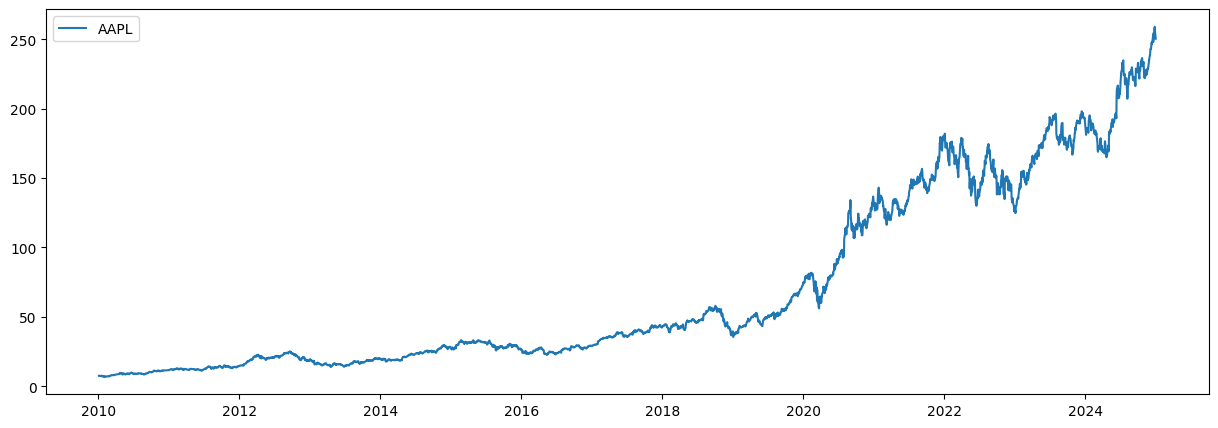

3810

In [21]:
pri_df = pd.read_parquet('data/daily_price.parquet', filters=[('TICKER', 'in', ['AAPL', 'MSFT', 'XOM', 'GOOGL', 'NVDA', 'INTC',
                         'AMD', 'AMZN', 'TSLA', 'NFLX', 'COST', 'AZN', 'ISRG', 'PEP', 'LIN', 'TMUS', 'CMCSA', 'CSCO', 'IBM', 'HON'])]).reset_index()

AAPL_df = pd.DataFrame()
AAPL_df['date'] = pri_df[pri_df['TICKER']=='AAPL']['date']
AAPL_df['PRC'] = pri_df[pri_df['TICKER']=='AAPL']['PRC']
AAPL_df['CFACPR'] = pri_df[pri_df['TICKER']=='AAPL']['CFACPR']
AAPL_df.index = pd.to_datetime(AAPL_df['date'])
AAPL_df.sort_index(inplace=True)
AAPL_df.drop(columns=['date'], inplace=True)

plt.figure(figsize=(15, 5))
plt.plot(AAPL_df.index, AAPL_df['PRC']/AAPL_df['CFACPR'], label='AAPL')
plt.legend()
plt.show()

del pri_df,AAPL_df

gc.collect()

/tmp/ipykernel_83688/1118654285.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2010-01-01', end='2025-12-31', interval='1d')
[*********************100%***********************]  1 of 1 completed


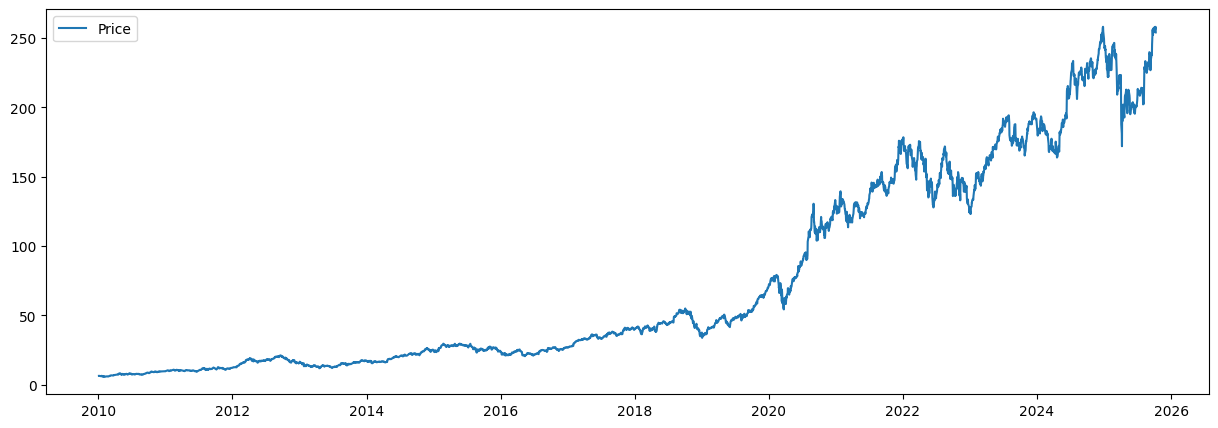

7542

In [4]:
import yfinance as yf

# 1달 주기로 데이터 다운로드
data = yf.download('AAPL', start='2010-01-01', end='2025-12-31', interval='1d')

plt.figure(figsize=(15, 5))
plt.plot(data.index, data['Close'], label='Price')
plt.legend()
plt.show()

del data, AAPL_df

gc.collect()